In [8]:
# %%
 

# # %% Convert the large xlsx file into a faster csv file - this takes some time..!
import dask
import pandas as pd
import numpy as np
import dask.dataframe as ddf
from dask.delayed import delayed
from sklearn.utils import axis0_safe_slice

convert_xlsx_to_csv = False

if convert_xlsx_to_csv:
    parts = dask.delayed(pd.read_excel)("../data/Example_MLE.xlsx")
    df_per_dask = ddf.from_delayed(parts)
    df_per_dask.to_csv("../data/Example_MLE.csv", single_file = True)


In [9]:
# %% Load the data
df_raw = pd.read_csv("../data/Example_MLE.csv",
                        index_col = 0,
                        low_memory= False
                    )
df_raw

Unnamed: 0.1           Unnamed: 1        Unnamed: 2        Unnamed: 3  \
0               NaN                  NaN               NaN               NaN   
1               NaN                  NaN               NaN               NaN   
2               NaN                  NaN               NaN               NaN   
3      BOLD_BIN_uri  OTU_ID;cluster_size  consensus_Domain  consensus_Phylum   
4      BOLD:AAZ0264    OTU3;size=2497841         Eukaryota        Arthropoda   
...             ...                  ...               ...               ...   
28568  BOLD:ACP1556      OTU36504;size=8         Eukaryota        Arthropoda   
28569  BOLD:AAB9578      OTU7609;size=77         Eukaryota        Arthropoda   
28570  BOLD:AAE4875      OTU28553;size=3         Eukaryota        Arthropoda   
28571  BOLD:AAF5823      OTU32740;size=2         Eukaryota        Arthropoda   
28572  BOLD:AAY0535      OTU36981;size=2         Eukaryota        Arthropoda   

            Unnamed: 4       Unnamed: 5        Unnamed: 6       Unnamed: 7  \
0                  NaN              NaN               NaN              NaN   
1                  NaN              NaN               NaN              NaN   
2                  NaN              NaN               NaN              NaN   
3      consensus_Class  consensus_Order  consensus_Family  consensus_Genus   
4              Insecta          Diptera     Sarcophagidae       Sarcophaga   
...                ...              ...               ...              ...   
28568          Insecta          Diptera      Pipunculidae        Verrallia   
28569          Insecta       Coleoptera     Curculionidae      Xyleborinus   
28570          Insecta      Lepidoptera     Yponomeutidae       Yponomeuta   
28571          Insecta      Lepidoptera      Ypsolophidae        Ypsolopha   
28572        Arachnida          Araneae       Gnaphosidae          Zelotes   

                  Unnamed: 8       Unnamed: 9  ...      Grassland.509  \
0                        NaN              NaN  ...           49.05569   
1                        NaN              NaN  ...           13.27097   
2                        NaN              NaN  ...              AUG-I   
3          consensus_Species  consensus score  ...  6945_2_G_klein_V8   
4       Sarcophaga_variegata                B  ...                  0   
...                      ...              ...  ...                ...   
28568        Verrallia_aucta                A  ...                  0   
28569  Xyleborinus_saxesenii                C  ...                  0   
28570    Yponomeuta_sedellus                C  ...                  0   
28571    Ypsolopha_asperella                A  ...                  0   
28572   Zelotes_subterraneus                A  ...                  0   

           Grassland.510          Urban.404          Urban.405  \
0              48.860921           47.75695         47.8103357   
1              13.544862           11.58147         10.8881576   
2                  AUG-I              AUG-I              AUG-I   
3      7147_1_G_klein_V8  8235_1_U_klein_V8  8131_3_U_klein_V8   
4                      0                 48                951   
...                  ...                ...                ...   
28568                  0                  0                  0   
28569                  0                  0                  0   
28570                  0                  0                  0   
28571                  0                  0                  0   
28572                  0                  0                  0   

           Grassland.511         Forest.647         Forest.648  \
0                47.8692         47.8224184           47.87829   
1               10.83086         10.9115418           10.81209   
2                  AUG-I              AUG-I              AUG-I   
3      8130_2_G_klein_V8  8131_3_F_klein_V8  8130_2_F_klein_V8   
4                    784                931                  0   
...                  ...                ...

In [10]:
# %% Split the data into BOLD BIN part and the habitat data

column_names = df_raw.keys()
habitat_types = ["agricultural", "Forest", "Grassland", "Urban"]

habitat_columns = [col for col in column_names for habitat_type in habitat_types if habitat_type in col]
non_habitat_columns = [col for col in column_names if not col in habitat_columns]

df_BOLD_raw = pd.DataFrame(df_raw.loc[4:,non_habitat_columns]).copy().fillna("")
df_BOLD_raw.rename(columns = {old_col_name : new_col_name for old_col_name, new_col_name in zip(non_habitat_columns,df_raw.loc[3,non_habitat_columns])}, inplace=True)
df_habitat_raw = df_raw[habitat_columns].fillna(0)

In [11]:
# %% Make dataframe BOLD nicer:
# - shorten the column "BOLD_BIN_uri"
# - split and shorten the column "OTU_ID;cluster_size"
# - add column "sum_reads_per_OTU"

df_BOLD_all = df_BOLD_raw.drop(["BOLD_BIN_uri", "OTU_ID;cluster_size"], axis = 1)

df_BOLD_all["BOLD_BIN_uri"] = [str(uri.replace("BOLD:", "")) for uri in  df_BOLD_raw['BOLD_BIN_uri']]
df_BOLD_all[["OTU_ID", "cluster_size"]] = df_BOLD_raw["OTU_ID;cluster_size"].str.split(";",expand=True,)
df_BOLD_all["OTU_ID"] = [id.replace("OTU", "") for id in  df_BOLD_all['OTU_ID']]
df_BOLD_all["cluster_size"] = [int(id.replace("size=", "")) for id in  df_BOLD_all['cluster_size']]
df_BOLD_all["sum_reads_per_OTU"] = df_raw.loc[4:, "habitat type"].astype(int)

In [12]:
# %% Make dataframe BOLD smaller:
# - delete all rows without an 'BOLD_BIN_uri'
# - delete all rows with 'sum_read_per_OTU' below a margin
# - delete all rows with 'consensus score' C

mask = (
    (df_BOLD_all["BOLD_BIN_uri"] != '')
    #& (df_BOLD_all["sum_reads_per_OTU"] > 10)
    #& (df_BOLD_all["consensus score"] != 'C')
    )
df_BOLD = df_BOLD_all[mask].copy()

In [13]:
# %% Make dataframe habitat nicer:
# - transpose it
# - rename columns as BIN features
# - create target variable "habitat_date"

df_habitat = df_habitat_raw.T.reset_index()

new_habitat_columns = {
    "index" : "habitat_type",
    0 : "lat",
    1 : "lon",
    2 : "date",
    3 : "ID"
}
features = [df_BOLD.loc[i, 'BOLD_BIN_uri'] if i in df_BOLD.index else '' for i in range(4,len(df_raw))]
new_habitat_columns.update({old_col_name : new_col_name for old_col_name, new_col_name in zip(range(4, len(df_raw)), features)})
# %%
df_habitat.rename(columns = new_habitat_columns, inplace=True)
df_habitat.drop(columns = [''], axis = 1, inplace = True)
df_habitat["habitat_type"] = [habitat_type for habitat in df_habitat["habitat_type"] for habitat_type in habitat_types if habitat_type in habitat]
df_habitat["date"] = df_habitat["date"].str[:3]
df_habitat["target"] = df_habitat["date"] + "_" + df_habitat["habitat_type"]

In [19]:
# %% Set up dataframe for training
X_duplicates = df_habitat.drop(columns = ["habitat_type","lat","lon","date","ID", "target"], axis = 1).astype(int)

X = X_duplicates.groupby(X_duplicates.columns, axis=1).sum()
        
X.to_csv("../data/X_train_complete.csv")
#(X == 0).sum(axis = 1).sum(axis=0) / (np.prod(X.shape))

In [37]:
y = df_habitat[["target"]]
#y = df_habitat["date"]
y.to_csv("../data/y_train_complete.csv")

In [39]:
import pyarrow.parquet as pq
X.to_parquet("../data/X_train_complete.parquet")
y.to_parquet("../data/y_train_complete.parquet")

In [22]:
import pandas as pd
import numpy as np

X = pd.read_csv("../data/X_train_complete.csv", index_col=0)
y = pd.read_csv("../data/y_train_complete.csv", index_col=0, squeeze = True)

In [42]:
X = pd.read_parquet("../data/X_train_complete.parquet")
y = pd.read_parquet("../data/y_train_complete.parquet")

In [23]:
X_dummy = X.copy()
X_dummy[X > 0] = 1

In [24]:
# %% Dimensionality reduction
#from sklearn.decomposition import TruncatedSVD
#
#svd = TruncatedSVD(random_state=42)
#X_svd = svd.fit_transform(X_dummy)

# %%
#from sklearn.decomposition import PCA

#pca = PCA(n_components=2)
#X_pca = pca.fit_transform(X)

# %%
#import plotly.express as plx
#
#fig = plx.scatter(x = X_svd[:,0], y = X_svd[:,1],
#    facet_col = df_habitat["habitat_type"],
#    color = df_habitat["date"],
#    title = "Separatation of the Data into Months and Hibitat Type"
#)
#fig.show()
#fig.write_html("Separatation_of_the_Data.html")

# # %%
# fig = plx.scatter(x = X_pca[:,0], y = X_pca[:,1],
#     facet_col = df_habitat["habitat_type"],
#     color = df_habitat["date"],
#     title = "Dimension Reduction to Visualize Separatation of the Months"
# )
# fig.update_xaxes(showline=False)
# fig.show()

In [26]:
# %%
from sklearn.model_selection import train_test_split

test_size = 0.25

if test_size > 0:
    X_train, X_test, X_dummy_train, X_dummy_test, y_train, y_test = train_test_split(
        X, X_dummy, y, test_size=test_size, stratify = y)
else:
    X_train, X_dummy_train, y_train = X, X_dummy, y

    X_test_raw = pd.read_csv("X_test_raw.csv", index_col = 0)
    
    X_test = pd.DataFrame(0, index=X_test_raw.index, columns = X_train.keys())

    for col in X_test_raw.keys():
        if col in X_test_raw.keys():
            X_test[col] = X_test_raw[col]
            
    X_dummy_test = X_test
    X_dummy_test[X_dummy_test > 0] = 1

X_train.shape

(1581, 8977)

In [28]:
X_test

AAA0001  AAA1236  AAA1255  AAA1260  AAA1471  AAA1496  AAA1513  AAA1697  \
1935        0        0        0        0        0        0        0        0   
409         0        0        0        0        0        0        0        0   
1538        0        0        0        0        0        0        0        0   
880         0        0        0        0        0        0       11        0   
157         0        0        0        0        0        0        0        0   
...       ...      ...      ...      ...      ...      ...      ...      ...   
1759        0        0        0        0        0        0        0        0   
1327        0        0        0        0        0        0        0        0   
103         0        0        0        0        0        0        0        0   
451         0        0        0        0        0        0        0        0   
1194        0        0        0        0        0        0        0        0   

      AAA2052  AAA2076  ...  AEJ6987  AEJ7049  AEJ7090  AEJ8030  AEJ8451  \
1935        0        0  ...        0        0        0        0        0   
409         0        0  ...        0        0        0        0        0   
1538        0        0  ...        0        0        0        0        0   
880         0        0  ...        0        0        0        0        0   
157         0        0  ...        0        0        0        0        0   
...       ...      ...  ...      ...      ...      ...      ...      ...   
1759        0        0  ...        0        0        0        0        0   
1327        0        0  ...        0        0        0        0        0   
103         0        0  ...        0        0        0        0        0   
451         0        0  ...        0        0        0        0        0   
1194        4        0  ...        0        0        0        0        0   

      AEJ8516  AEJ8836  AEJ9485  AEK1974  AEK2564  
1935        0        0        0        0        0  
409         0        0        0        0        0  
1538        0        0        0        0        0  
880         0        0        0        0        0  
157         0        0        0        0        0  
...       ...      ...      ...      ...      ...  
1759        0        0        0        0        0  
1327        0        0        0        0        0  
103         0        0        0        0        0  
451         0        0        0        0        0  
1194        0        0        0        0        0  

[528 rows x 8977 columns]

In [29]:
# %%
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
# %%
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train_scaled, y_train)


In [32]:
# %%
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

distributions = {"n_estimators" : [100, 200, 300, 500, 1000, 2000, 2500, 3000],
                 "criterion" : ['gini', "entropy"], 
                 "max_depth": [2,3,4,5,7,10,15, 17, 20, 25], 
                 "min_samples_split" : [2,3,4,5,7,10,15,20], 
                 "min_samples_leaf" : [1,2,3,4,5,7,10,13,17,20] 
                }

randomizedSearchCV = False

if randomizedSearchCV:
    rscv = RandomizedSearchCV(clf, distributions, random_state=0, n_iter = 50)
    clf = rscv.fit(X_train_smote, y_train_smote)
    clf_dummy = rscv.fit(X_dummy_train_smote, y_train_smote)
    
else:
    clf = RandomForestClassifier(n_estimators = 200,
                                 min_samples_split = 4,
                                 min_samples_leaf = 1,
                                 max_depth = 15,
                                 criterion = 'gini')
    clf.fit(X_train_smote, y_train_smote)
    


In [ ]:
import pickle 
import joblib

filename = '../data/random_forest_model'

joblib.dump(clf, filename + '.joblib')
pickle.dump(clf, open(filename + '.sav', 'wb'))

In [103]:
X_dummy_train_smote, y_dummy_train_smote = oversample.fit_resample(X_dummy_train, y_train)

In [78]:
clf_dummy = RandomForestClassifier(n_estimators = 200,
                                 min_samples_split = 4,
                                 min_samples_leaf = 1,
                                 max_depth = 15,
                                 criterion = 'gini')
    
clf_dummy.fit(X_dummy_train_smote, y_dummy_train_smote)

RandomForestClassifier(max_depth=15, min_samples_split=4, n_estimators=200)

In [94]:
import pickle 
import joblib

filename = 'random_forest_dummy_model'
pickle.dump(clf_dummy, open(filename + '.sav', 'wb'))
joblib.dump(clf_dummy, filename + '.joblib', compress=3)

['random_forest_dummy_model.joblib']

In [111]:
#y_predict = joblib.load("random_forest_model.joblib").predict(X_test_scaled)

#y_predict = clf.predict(X_test_scaled)
#y_predict = clf_dummy.predict(X_dummy_test)

y_predict = joblib.load("random_forest_dummy_model.joblib").predict(X_dummy_test)

y_predict

array(['AUG_agricultural', 'AUG_Grassland', 'AUG_Grassland',
       'AUG_Grassland', 'AUG_agricultural', 'AUG_Grassland',
       'AUG_agricultural', 'AUG_Grassland', 'AUG_agricultural',
       'AUG_Grassland', 'AUG_Grassland', 'APR_Grassland', 'JUL_Forest',
       'AUG_agricultural', 'AUG_agricultural', 'AUG_agricultural',
       'AUG_agricultural', 'AUG_Grassland', 'JUL_Grassland', 'JUL_Urban'],
      dtype=object)

In [112]:
date = "JUL"
h_type = "Altgras"

y_predict = pd.DataFrame(y_predict, columns = ["Prediction_for_" + date + "_" + h_type], index = X_test.index)
y_predict.to_csv("Predictions_CL_Results_" + date + "_" + h_type + ".csv")

In [88]:
# %%
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(y_test, y_predict)
cl_report = classification_report(y_test, y_predict)

/home/karl/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/karl/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/karl/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/karl/.local/lib/python3.8/site-packages/sklearn/

<AxesSubplot:>

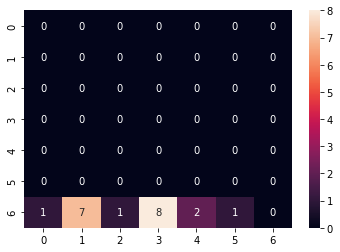

In [89]:
# %%
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(conf_matrix, annot=True)

In [90]:
# %%
print(cl_report)

                  precision    recall  f1-score   support

   APR_Grassland       0.00      0.00      0.00       0.0
   AUG_Grassland       0.00      0.00      0.00       0.0
       AUG_Urban       0.00      0.00      0.00       0.0
AUG_agricultural       0.00      0.00      0.00       0.0
   JUL_Grassland       0.00      0.00      0.00       0.0
       JUL_Urban       0.00      0.00      0.00       0.0
JUL_agricultural       0.00      0.00      0.00      20.0

        accuracy                           0.00      20.0
       macro avg       0.00      0.00      0.00      20.0
    weighted avg       0.00      0.00      0.00      20.0



In [ ]:
rscv.best_params_

In [ ]:
                  precision    recall  f1-score   support

      APR_Forest       0.66      0.86      0.75        44
   APR_Grassland       0.46      0.38      0.42        34
       APR_Urban       0.78      0.50      0.61        28
APR_agricultural       0.53      0.72      0.61        36
      AUG_Forest       0.76      0.88      0.81        40
   AUG_Grassland       0.54      0.42      0.47        31
       AUG_Urban       0.71      0.65      0.68        23
AUG_agricultural       0.76      0.74      0.75        34
      JUL_Forest       0.72      1.00      0.84        26
   JUL_Grassland       0.89      0.38      0.53        21
       JUL_Urban       0.61      0.65      0.63        17
JUL_agricultural       0.64      0.82      0.72        22
      MAY_Forest       0.67      0.75      0.71        53
   MAY_Grassland       0.50      0.29      0.36        42
       MAY_Urban       0.67      0.61      0.63        33
MAY_agricultural       0.65      0.68      0.67        44

        accuracy                           0.65       528
       macro avg       0.66      0.65      0.64       528
    weighted avg       0.65      0.65      0.64       528

In [ ]:
A = {'n_estimators': 2000,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_depth': 15,
 'criterion': 'gini'}